# Import libraries and set random seed

In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model
from graph_deep_decoder import utils

# %matplotlib qt

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Creating random SBM graph

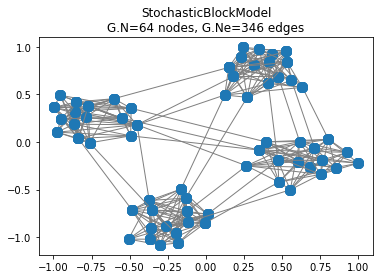

In [2]:
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64  # 256  # 64
Gs['k'] = 4  # 4
Gs['type_z'] = ds.CONT
Gs['p'] = 0.7 
Gs['q'] = 0.015

G = ds.create_graph(Gs, SEED)
A = np.asarray(G.W.todense())
L = G.L.todense()
G.plot()

# Create graph filter

In [3]:
K = 3
hs = np.random.rand(K)
hs /= np.sum(abs(hs))
h_params = {'type': 'FixedH', 'S': 'A', 'hs': hs, 'H_norm': False}
H = utils.create_filter(A, h_params)
eigval_H, V_H = utils.ordered_eig(H)

# Jacobian of 2 Layer Decoder

In [4]:
fts = 150 
dec = GraphDecoder(fts, H)

In [5]:
JJ_an = dec.analytical_squared_jacobian()
Sigmas_an, U_an = utils.ordered_eig(JJ_an)
U_an = utils.choose_eig_sign(U_an, V_H)

JJ_aut = dec.autograd_squared_jacobian()
Sigmas_aut, U_aut = utils.ordered_eig(JJ_aut)
U_aut = utils.choose_eig_sign(U_aut, V_H)

# Denoise signals - same graph

In [14]:
n_signals = 100
n_p = 0.1
epochs = 500
lr = 0.001
fts = 150
scale_std = .0025

err = np.zeros((3, epochs, n_signals))
for i in range(n_signals):
    dec = GraphDecoder(fts, H, scale_std=scale_std)
    
    # Create signals
    x = G.info['node_com']/np.linalg.norm(G.info['node_com'])
    noise = np.random.randn(x.size)*np.sqrt(n_p/x.size)
    x_n = x + noise
    noise /= np.linalg.norm(noise)

    # Create models
    model_x = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_noise = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_x_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

    # Train modesls
    _, err[0, :, i], _ = model_x.fit(x, x, reduce_err=True)
    _, err[1, :, i], _ = model_noise.fit(noise, noise, reduce_err=True)
    _, err[2, :, i], _ = model_x_n.fit(x_n, x, reduce_err=True)
    
    print(i, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [6]:
# np.save('../results/analize_jacobian/piecewise_signal_gcg.npy', err)
# epochs = 500
# err = np.load('../results/analize_jacobian/piecewise_signal_gcg.npy')

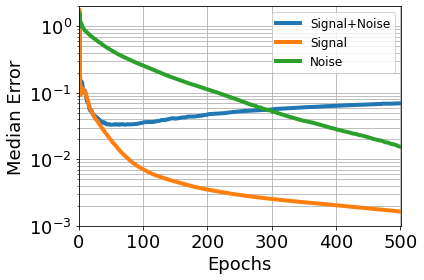

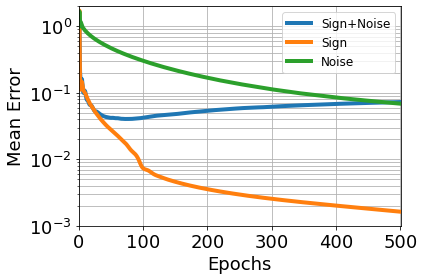

In [17]:
# Plot median error
err_med = np.median(err, axis=2)
fig = plt.figure()
plt.semilogy(err_med[2,:], linewidth=4, label='Signal+Noise')
plt.semilogy(err_med[0,:], linewidth=4, label='Signal')
plt.semilogy(err_med[1,:], linewidth=4, label='Noise')
plt.legend(prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Median Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

path = '../results/analize_jacobian/'
# fig.savefig(path + 'fit_x_noise_x_n.eps')
fig.savefig(path + 'fit_x_noise_x_n.pdf')

# Plot mean error
err_mean = np.mean(err, axis=2)
fig2 = plt.figure()
plt.semilogy(err_mean[2,:], linewidth=4, label='Sign+Noise')
plt.semilogy(err_mean[0,:], linewidth=4, label='Sign')
plt.semilogy(err_mean[1,:], linewidth=4, label='Noise')
plt.legend(prop={'size': 12})
plt.grid(True, which='both')
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Mean Error',fontsize=18)
plt.xlim([0, epochs+1])
plt.ylim([1e-3, 2])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

In [23]:
plt.show()